## Graphs for the 48 min recording (ripple range)

In [1]:
import Ipynb_importer

In [7]:
import TrodesReader
from collections import deque
import numpy as np
import math
from scipy import signal
import matplotlib.pyplot as plt
from pprint import pprint

In [8]:
def bandpass_filter(filter_name, flattened_array, sampling_freq, order, lowcut, highcut):
    if filter_name == 'elliptical':
        sos = signal.ellip(order, 0.01, 120, [lowcut, highcut], btype='bp', output='sos', fs=sampling_freq)
    if filter_name == 'butterworth':
        sos = signal.butter(order, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')
    if filter_name == 'cheby1':
        sos = signal.cheby1(order, 1, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')
    if filter_name == 'cheby2':
        sos = signal.cheby2(order, 15, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')

    y = signal.sosfiltfilt(sos, flattened_array)

    return y


def calculate_rms(buffer):
    square_summed = 0
    for k in buffer:
        square_summed += (k ** 2)

    return math.sqrt(square_summed / len(buffer))


def filter_then_rms(buffer, low_cut, high_cut, threshold):
    filtered_buffer = bandpass_filter('butterworth', buffer, lfp_sampling_rate, 1, low_cut, high_cut)
    current_rms = calculate_rms(filtered_buffer)
    return current_rms >= threshold

In [96]:
# this is the 48 min data
data_path = r'C:\Users\mengz\Box\20211207_E1_124311\20211207_E1_124311.LFP_nt28ch1.dat'
time_path = r'C:\Users\mengz\Box\20211207_E1_124311\20211207_E1_124311.timestamps.dat'

In [97]:
data = TrodesReader.readTrodesExtractedDataFile(data_path)
pprint(data)

{'accelerometer': '1',
 'autosettle': '0',
 'byte_order': 'little endian',
 'clockrate': '30000',
 'commit_tag': 'heads/develop2-0-g14289d93',
 'compile_date': 'Sep 16 2021',
 'compile_time': '10:58:19',
 'controller_firmware': '3.17',
 'controller_serialnum': '00104 00153',
 'data': array([( -13,), (-245,), (-495,), ..., (-868,), (-883,), (-905,)],
      dtype=[('voltage', '<i2')]),
 'description': 'LFP data for one channel',
 'fields': '<voltage int16>',
 'first_timestamp': '85512637',
 'gyro': '1',
 'headstage_firmware': '3.0',
 'headstage_serialnum': '00407 00125',
 'low_pass_filter': '200',
 'magnetometer': '0',
 'ntrode_channel_number': '1',
 'ntrode_id': '28',
 'num_channels': '4',
 'original_file': '20211207_E1_124311.rec',
 'qt_version': '5.15.1',
 'reference': 'on',
 'referencechannel': '1',
 'referencentrode': '27',
 'smartref': '1',
 'system_time_at_creation': '1638902627739',
 'time_offset': '0',
 'timestamp_at_creation': '85267011',
 'trodes_version': '2.2.3',
 'voltage_s

<string>:69: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.


In [98]:
time = TrodesReader.readTrodesExtractedDataFile(time_path)
pprint(time)

{'accelerometer': '1',
 'autosettle': '0',
 'byte_order': 'little endian',
 'clockrate': '30000',
 'commit_tag': 'heads/develop2-0-g14289d93',
 'compile_date': 'Sep 16 2021',
 'compile_time': '10:58:19',
 'controller_firmware': '3.17',
 'controller_serialnum': '00104 00153',
 'data': array([( 85512640,), ( 85512660,), ( 85512680,), ..., (156761480,),
       (156761500,), (156761520,)], dtype=[('time', '<u4')]),
 'decimation': '20',
 'description': 'LFP timestamps',
 'fields': '<time uint32>',
 'first_timestamp': '85512637',
 'gyro': '1',
 'headstage_firmware': '3.0',
 'headstage_serialnum': '00407 00125',
 'magnetometer': '0',
 'original_file': '20211207_E1_124311.rec',
 'qt_version': '5.15.1',
 'smartref': '1',
 'system_time_at_creation': '1638902627739',
 'time_offset': '0',
 'timestamp_at_creation': '85267011',
 'trodes_version': '2.2.3'}


In [99]:
start_time = int(time['first_timestamp'])
time_data = []
for i in time['data']:
    time_data.append((i[0]-start_time)/30000)

In [100]:
# check the total recording length
print(time_data[len(time_data)-1]/60)

39.58271277777778


In [101]:
lfp_sampling_rate = 1500
lfp_sampling_period = (1/lfp_sampling_rate)*(10**9)

#lower_bound = 10000
#upper_bound = 19000
sw_lower = 5
sw_upper = 15
ripple_lower = 140
ripple_upper = 250
num_std = 3

In [102]:
all_data = data['data']
lfp_data = []
for i in all_data:
    lfp_data.append(i[0])

ripple_lfp_data = bandpass_filter('butterworth', lfp_data, lfp_sampling_rate, 1, ripple_lower, ripple_upper)
sw_lfp_data = bandpass_filter('butterworth', lfp_data, lfp_sampling_rate, 1, sw_lower, sw_upper)

<IPython.core.display.Javascript object>


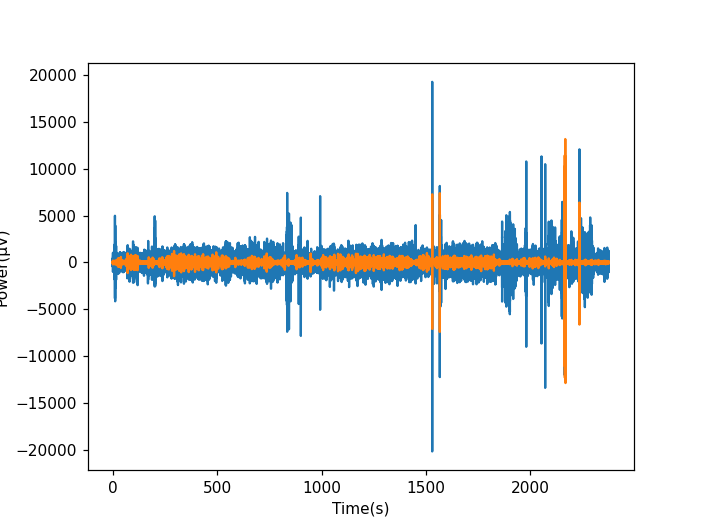

In [103]:
%matplotlib notebook
fig1 = plt.figure()
plt.plot(time_data,sw_lfp_data)
plt.plot(time_data,ripple_lfp_data)
plt.xlabel('Time(s)')
plt.ylabel('Power(µV)')
plt.show()

In [104]:
print(len(time_data))
print(len(lfp_data))

3562445
3562445


In [105]:
offline_rms = []
offline_time = []
for i in range(499, len(lfp_data)):
    current_buffer = ripple_lfp_data[i-499:i]
    current_rms = calculate_rms(current_buffer)
    if(current_rms<=250):
        offline_rms.append(current_rms)
        offline_time.append(time_data[i])

In [107]:
online_rms = []
online_time = []
for i in range(499, len(lfp_data)):
    current_buffer = lfp_data[i-499:i]
    current_filtered = bandpass_filter('butterworth', current_buffer, lfp_sampling_rate, 1, ripple_lower, ripple_upper)
    current_rms = calculate_rms(current_filtered)
    if(current_rms<=250):
        online_rms.append(current_rms)
        online_time.append(time_data[i])

In [110]:
avg_offline = np.mean(offline_rms)
std_offline = np.std(offline_rms)
threshold_offline = avg_offline + num_std*std_offline
print(avg_offline)
print(std_offline)
print(threshold_offline)

37.87924231276903
22.554859583901347
105.54382106447306


In [111]:
avg_online = np.mean(online_rms)
std_online = np.std(online_rms)
threshold_online = avg_online + num_std*std_online
print(avg_online)
print(std_online)
print(threshold_online)

37.76263949789473
22.481484176540686
105.20709202751678


<IPython.core.display.Javascript object>


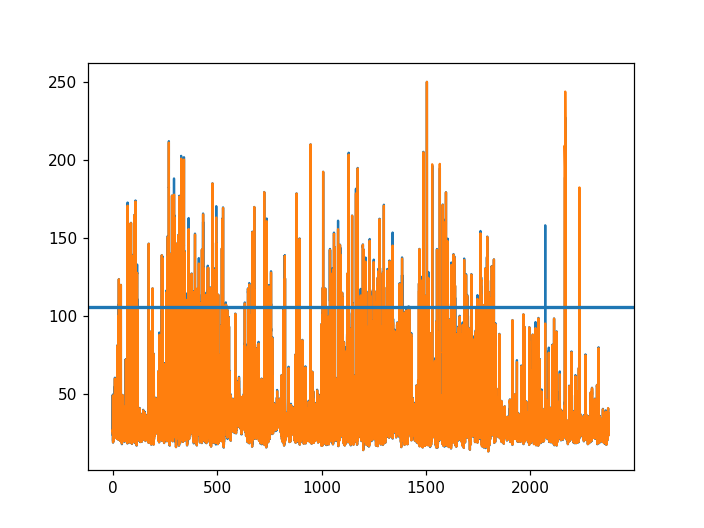

In [112]:
fi2 = plt.figure()
plt.plot(online_time, online_rms)
plt.plot(offline_time, offline_rms)
plt.axhline(y=threshold_online)
plt.axhline(y=threshold_offline)
plt.show()

In [114]:
zscore_online = []

for i in range(0,len(online_rms)):
    zscore_online.append((online_rms[i]-avg_online)/std_online)

In [115]:
zscore_offline = []

for i in range(0,len(offline_rms)):
    zscore_offline.append((offline_rms[i]-avg_offline)/std_offline)

<IPython.core.display.Javascript object>


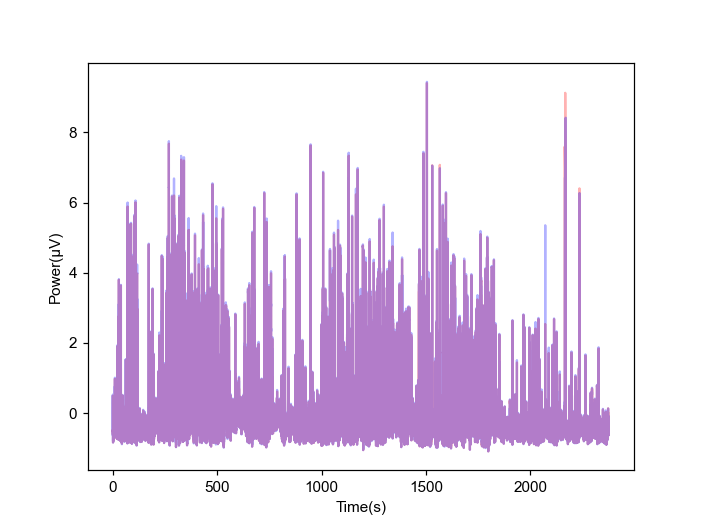

In [117]:
%matplotlib notebook
fig3 = plt.figure()
plt.plot(offline_time, zscore_offline,color='r',alpha=0.3)
plt.plot(online_time, zscore_online,color='b',alpha=0.3)
plt.xlabel('Time(s)')
plt.ylabel('Power(µV)')
plt.show()

In [118]:
online_decision = [False, False]
online_stimulation = []

for i in range(0,len(online_rms)):
    online_decision.append(online_rms[i]>threshold_online)
    current_stimulation = True
    for m in range(len(online_decision)-3,len(online_decision)):
        if not online_decision[m]:
            current_stimulation = False
    online_stimulation.append(current_stimulation)    

In [119]:
online_decision.pop(0)
online_decision.pop(0)

False

<IPython.core.display.Javascript object>


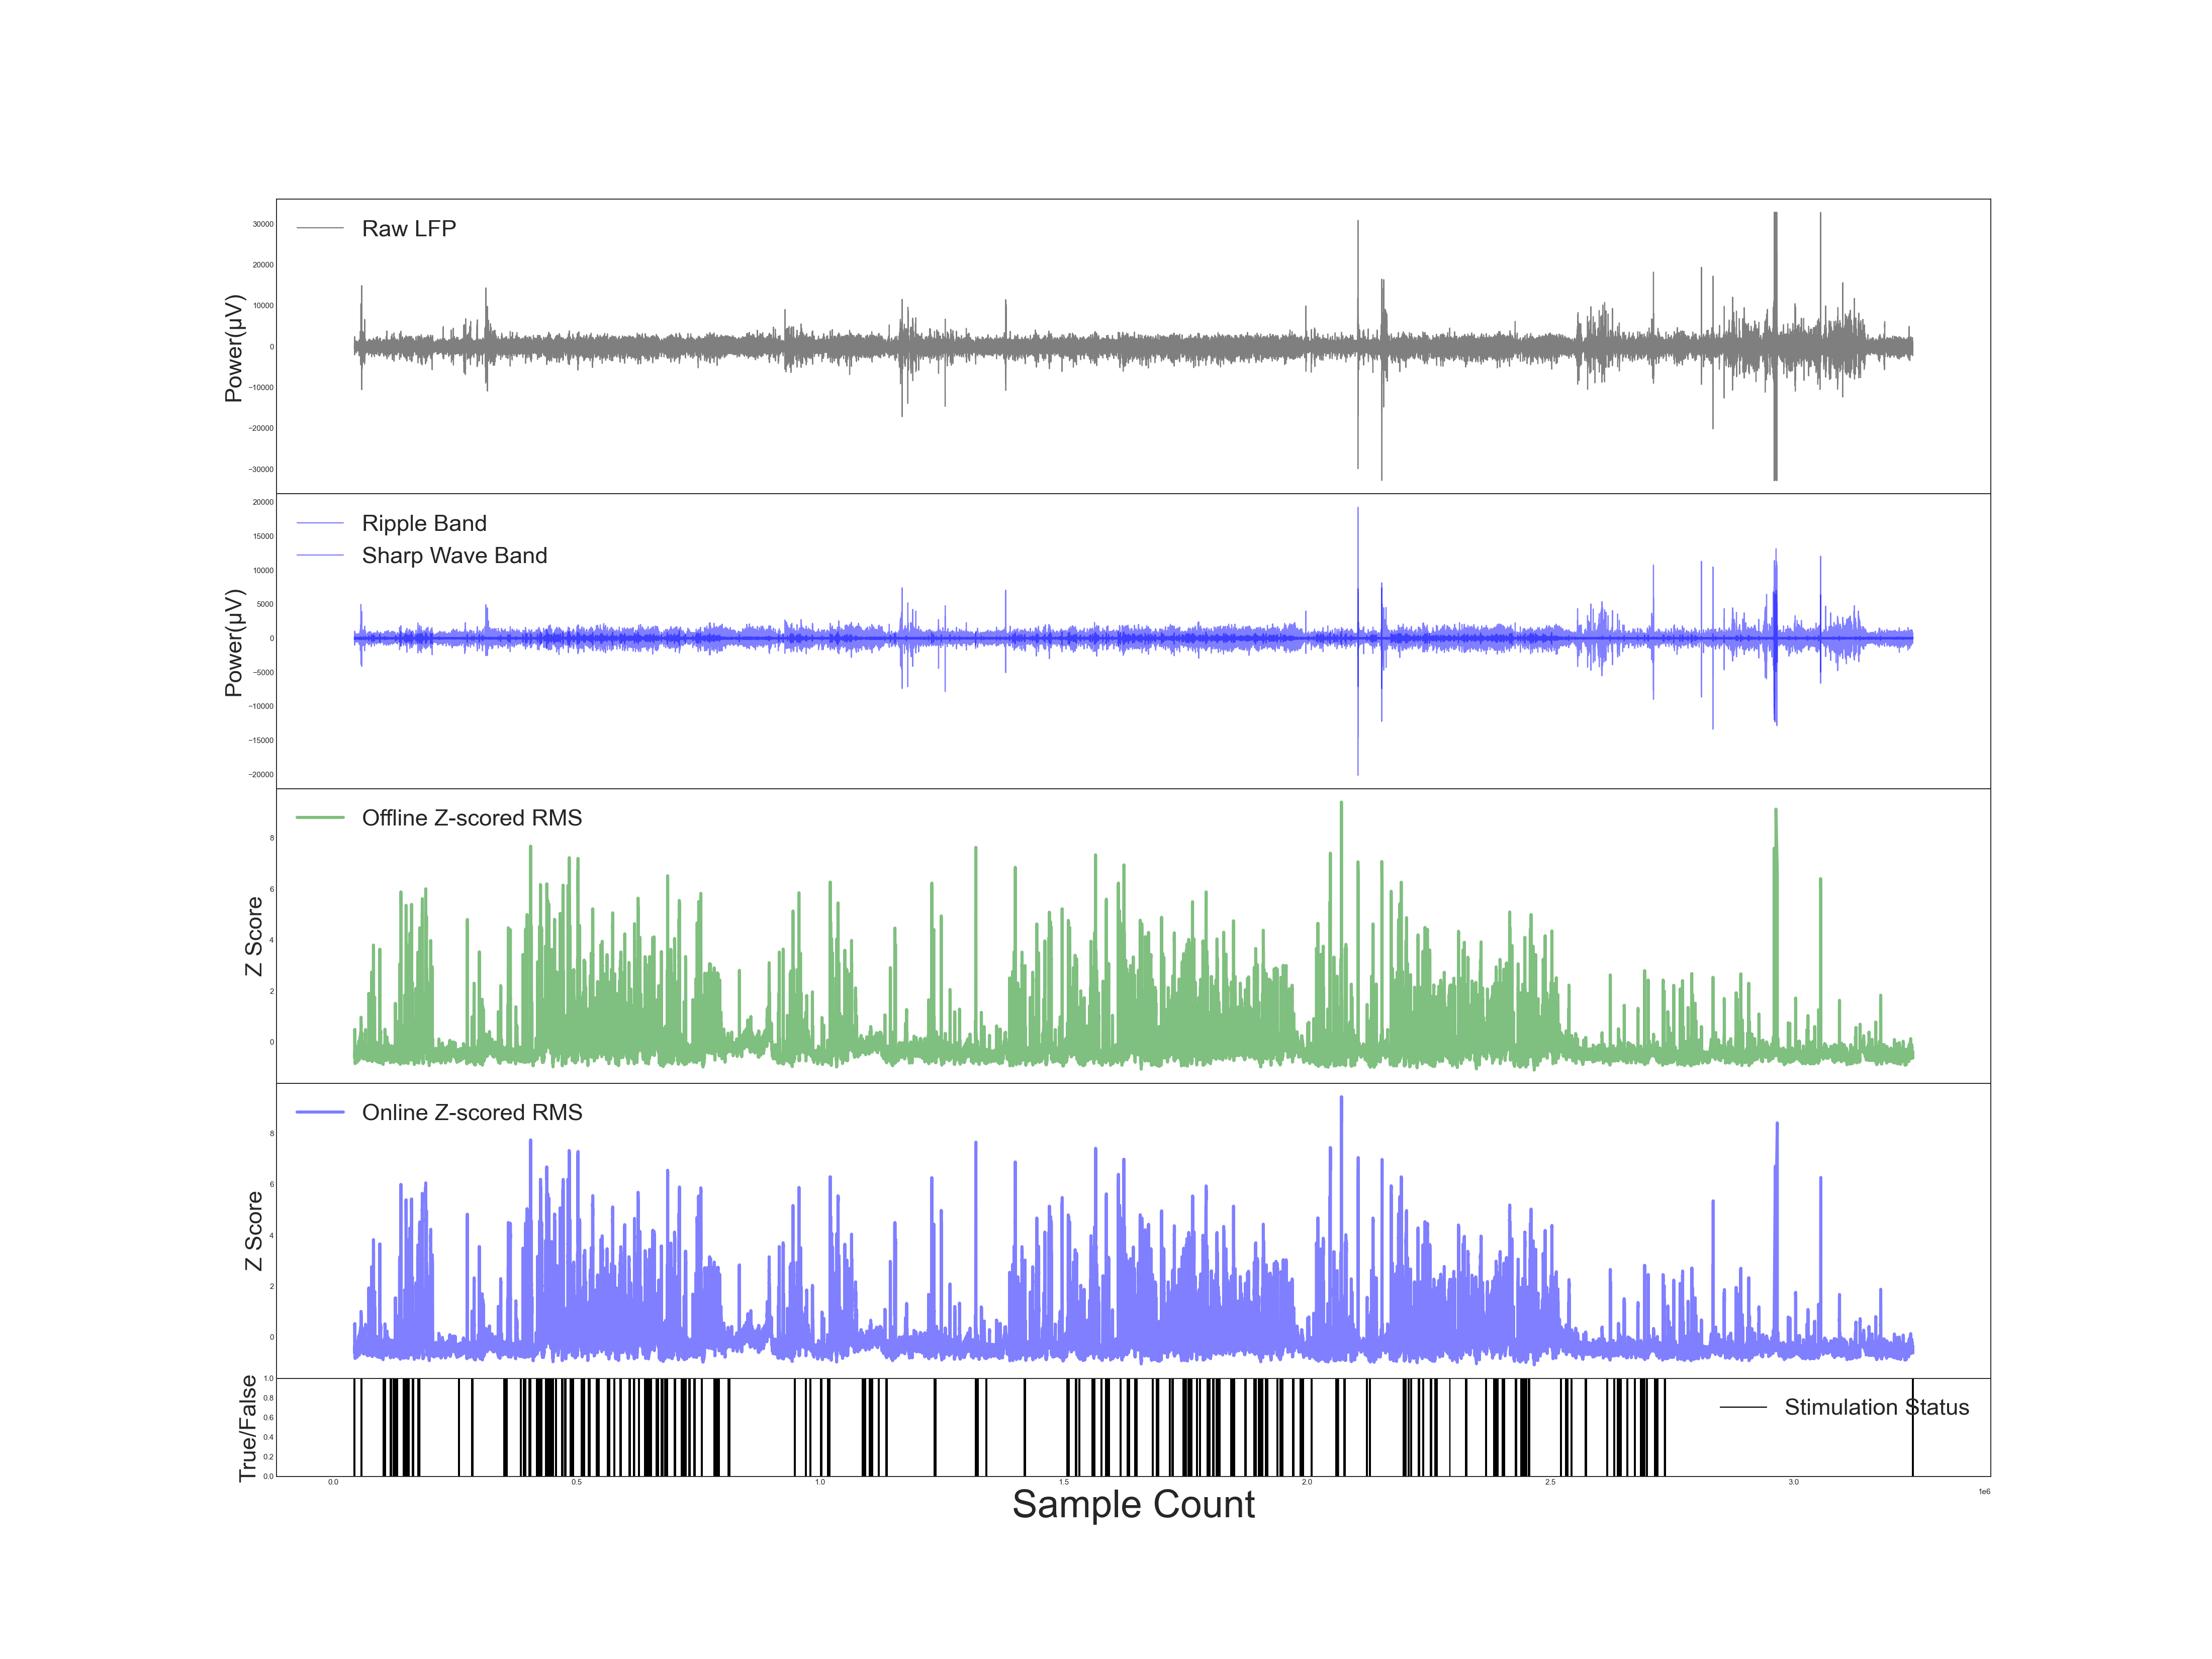

In [120]:
fig4 = plt.figure(figsize=(40, 30))
plt.style.use("seaborn-white")
grid1 = plt.GridSpec(13, 1, wspace=0, hspace=0)
ax1 = plt.subplot(grid1[0:3, 0:1])
ax2 = plt.subplot(grid1[3:6, 0:1])
ax3 = plt.subplot(grid1[6:9, 0:1])
ax4 = plt.subplot(grid1[9:12, 0:1])
ax5 = plt.subplot(grid1[12, 0:1])

ax1.plot(lfp_data[499:len(lfp_data)], color='k', alpha=0.5, label='Raw LFP')
ax1.set_ylabel("Power(µV)", fontsize=30)
ax1.legend(fontsize=30)

ax2.plot(ripple_lfp_data[499:len(ripple_lfp_data)], color='b', alpha=0.5, label='Ripple Band')
ax2.plot(sw_lfp_data[499:len(sw_lfp_data)], color='b', alpha=0.5, label='Sharp Wave Band')
ax2.set_ylabel("Power(µV)", fontsize=30)
ax2.legend(fontsize=30)

ax3.plot(offline_time, zscore_offline, color='g', linewidth='4', alpha=0.5, label='Offline Z-scored RMS')
ax3.set_ylabel("Z Score", fontsize=30)
ax3.legend(fontsize=30)

ax4.plot(online_time, zscore_online, color='b', linewidth='4', alpha=0.5, label='Online Z-scored RMS')
ax4.set_ylabel("Z Score", fontsize=30)
ax4.legend(fontsize=30)

for s in range(0,len(online_stimulation)):
    if online_stimulation[s]:
        ax5.axvline(x=s, color='k')
        
ax5.set_ylabel("True/False", fontsize=30)
ax5.legend(['Stimulation Status'], fontsize=30)
ax5.set_xlabel('Sample Count', fontsize=50)

plt.show()